Created by Stav Nimrod, June 2023.

### Donwload Data

In [ ]:
import json
import os

# Installing the Kaggle package
!pip install kaggle

#Important Note: complete this with your own key - after running this for the first time remmember to **remove** your API_KEY
api_token = {"username":"?","key":"?"}


# creating kaggle.json file with the personal API-Key details
# You can also put this file on your Google Drive
!mkdir /root/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Step 1: Download the dataset
!kaggle datasets download -d succinctlyai/midjourney-texttoimage
!unzip midjourney-texttoimage.zip

 85% 44.0M/51.8M [00:00<00:00, 72.9MB/s]
100% 51.8M/51.8M [00:00<00:00, 63.9MB/s]
Archive:  midjourney-texttoimage.zip
  inflating: general-01_2022_06_20.json  
  inflating: general-01_2022_06_21.json  
  inflating: general-01_2022_06_22.json  
  inflating: general-01_2022_06_23.json  
  inflating: general-01_2022_06_24.json  
  inflating: general-01_2022_06_25.json  
  inflating: general-01_2022_06_26.json  
  inflating: general-01_2022_06_27.json  
  inflating: general-01_2022_06_28.json  
  inflating: general-01_2022_06_29.json  
  inflating: general-01_2022_06_30.json  
  inflating: general-01_2022_07_01.json  
  inflating: general-01_2022_07_02.json  
  inflating: general-01_2022_07_03.json  
  inflating: general-01_2022_07_04.json  
  inflating: general-01_2022_07_05.json  
  inflating: general-01_2022_07_06.json  
  inflating: general-01_2022_07_07.json  
  inflating: general-01_2022_07_08.json  
  inflating: general-01_2022_07_09.json  
  inflating: general-01_2022_07_10.json  

### Data Parsing

In [ ]:
import json
import os
from collections import defaultdict
import re
from dataclasses import dataclass
import pandas as pd

# Define the constants for message types
COMPONENTS_FOR_INITIAL_AND_VARIATION = set(['U1', 'U2', 'U3', 'U4', '⟳', 'V1', 'V2', 'V3', 'V4'])
COMPONENTS_FOR_UPSCALE = set(['Make Variations', 'Upscale to Max', 'Light Upscale Redo'])

# Define helper functions for message parsing
def get_message_type(message):
    for components in message["components"]:
        for component in components["components"]:
            if component["label"] in COMPONENTS_FOR_INITIAL_AND_VARIATION:
                if "Upscaled" in message["content"]:
                    return "INCONCLUSIVE"
                return "INITIAL_OR_VARIATION"
            elif component["label"] in COMPONENTS_FOR_UPSCALE:
                return "UPSCALE"
    return "TEXT_MESSAGE"

def get_prompt(message):
    content = message["content"].replace("\n", " ")
    match = re.search("\\*\\*(.*?)\\*\\*", content)
    if match:
        return match.group()[2:-2]

def get_generated_image_url(message):
    attachments = message["attachments"]
    if len(attachments) == 1:
        return attachments[0]["url"]

# Define the data class for user requests
@dataclass
class UserRequest:
    prompt: str
    generated_url: str

# Walk through the directory and compile a list of JSON file paths
filepaths = []
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        if filename.endswith(".json"):
            filepaths.append(os.path.join(dirname, filename))
print(f"Found {len(filepaths)} files.")

# Parse the JSON files and categorize the messages by type
messages_by_type = defaultdict(list)
for filepath in filepaths:
    with open(filepath, "r") as f:
        content = json.load(f)
        if "messages" in content and isinstance(content["messages"], list):
            for single_message_list in content["messages"]:
                if len(single_message_list) == 1:
                    message = single_message_list[0]
                    message_type = get_message_type(message)
                    messages_by_type[message_type].append(message)

print("Message counts:")
for mtype, messages in messages_by_type.items():
    print("\t", mtype, len(messages))

# Extract user prompts and generated image URLs from 'INITIAL_OR_VARIATION' messages
user_requests = []
for m in messages_by_type["INITIAL_OR_VARIATION"]:
    prompt = get_prompt(m)
    generated_url = get_generated_image_url(m)
    if prompt and generated_url:
        user_requests.append(UserRequest(prompt, generated_url))

print(f"Parsed {len(user_requests)} user requests from {len(messages_by_type['INITIAL_OR_VARIATION'])} messages.")

# Convert the list of UserRequest objects into a DataFrame
df = pd.DataFrame([r.__dict__ for r in user_requests])

Found 274 files.
Message counts:
	 INITIAL_OR_VARIATION 145822
	 UPSCALE 102249
	 TEXT_MESSAGE 20309
	 INCONCLUSIVE 43
Parsed 145080 user requests from 145822 messages.


In [ ]:
# This did not affected results,
# furthermore there are prompts with slight changes that wont be captured using
# this method and manually seeking duplicates can affect representation of a
# subgroup generated imaged(POS/NEG).
# Thus decided not dropping duplicated as they spread fairly equal among POS/NEG.
# more elaborated in the paper.

# df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(145080, 2)

In [ ]:
# Set pandas options
pd.set_option("max_colwidth", None)
pd.set_option("max_seq_items", None)

df.head()

,prompt,generated_url
0,"<https://s.mj.run/KXHtj56_sek> black paper + female pleasure + symetrical + gun + skull + golden ratio + elements + gold + neon + baroque + rococco + white + ink + tarot card with ornate border frame + marc simonetti, paul pope, peter mohrbacher, detailed, intricate ink illustration.",https://cdn.discordapp.com/attachments/985982631579648000/996193165348446278/fb01_black_paper__female_pleasure__symetrical__gun__skull__gold_d0482b54-9958-4ab8-93ef-4f4201e9c121.png
1,<https://s.mj.run/DNY70ji_yvU> human faces —no human faces,https://cdn.discordapp.com/attachments/983464264897552455/996171551282057257/isocor_human_faces_55970d8b-b74a-4e4a-8a80-8ace1797405e.png
2,<https://s.mj.run/DNY70ji_yvU> human faces —no human faces,https://cdn.discordapp.com/attachments/983464264897552455/996170802451992646/isocor_human_faces_bd1f5e8c-e335-4f91-afd3-6a597d35ad67.png
3,<https://s.mj.run/DNY70ji_yvU> human faces —no human faces,https://cdn.discordapp.com/attachments/983464264897552455/996170644775514182/isocor_human_faces_9a464878-b467-4bcb-ae14-1556d4dbfe3b.png
4,<https://s.mj.run/DNY70ji_yvU> human faces —no human faces,https://cdn.discordapp.com/attachments/983464264897552455/996170593651134514/isocor_human_faces_76e22842-a128-4cf5-a5db-3638f09d7840.png


### Sentiment Analysis

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.4 MB/s eta 0:00:00


This part is computationally heavy and takes alot of time to proccess(make sure you are using GPU)

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
from transformers import pipeline
from tqdm import tqdm

# Initialize the Hugging Face sentiment analysis pipeline with GPU support
nlp = pipeline('sentiment-analysis', device=0)  # to utilize GPU

def get_sentiment(text):
    # Truncate the text to the maximum length of 512 tokens
    text = text[:512]
    result = nlp(text)[0]
    # Return the score of the sentiment
    if result['label'] == 'NEGATIVE':
        return -result['score']
    else:
        return result['score']

# Apply the function to the 'prompt' column and add the results to a new 'sentiment' column
df['sentiment'] = [get_sentiment(x) for x in tqdm(df['prompt'])]


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
100%|██████████| 145080/145080 [18:41<00:00, 129.35it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save data
df.to_csv('/content/drive/MyDrive/BGU/Courses/Data_mining/Project/Data/df.csv', index=False)

In [ ]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/BGU/Courses/Data_mining/Project/Data/df.csv')
df.head()

,prompt,generated_url,sentiment
0,"<https://s.mj.run/DujnW3rZ-OI> brutalist brutalism harbor, futuristic futurism industrial, concrete rusty metal ocean sea, crowds of workers, arial photograph angle --ar 16:9",https://cdn.discordapp.com/attachments/991294588755116102/996891096388993094/Kevinton_brutalist_brutalism_harbor_futuristic_futurism_industr_05ad011f-b631-4ae5-800e-0be2a1602b66.png,-0.988209
1,"brutalism harbor, futuristic futurism industrial, concrete rusty metal ocean sea --ar 16:9",https://cdn.discordapp.com/attachments/991294588755116102/996890702908760219/Kevinton_brutalism_harbor_futuristic_futurism_industrial_concre_dd07e2e0-d62e-47b8-a612-b25a1a671ff1.png,-0.979741
2,"brutalist brutalism harbor, futuristic futurism industrial, concrete rusty metal ocean sea, crowds of workers, arial photograph angle --ar 16:9",https://cdn.discordapp.com/attachments/991294588755116102/996888498076397699/Kevinton_brutalist_brutalism_harbor_futuristic_futurism_industr_06135d25-630b-4f6a-8316-e3aa40e47ff9.png,-0.817788
3,killzone enviroment building,https://cdn.discordapp.com/attachments/991294588755116102/996887261750755428/Kevinton_killzone_enviroment_building_9038c858-514d-427c-942c-e08bbeb5e184.png,-0.855028
4,take me to the backrooms,https://cdn.discordapp.com/attachments/989358635886981161/996887121275133952/aceclash_take_me_to_the_backrooms_01d9051f-06f8-4de4-acaa-221936b3d7be.png,0.500249


In [ ]:
df.shape

(145080, 3)

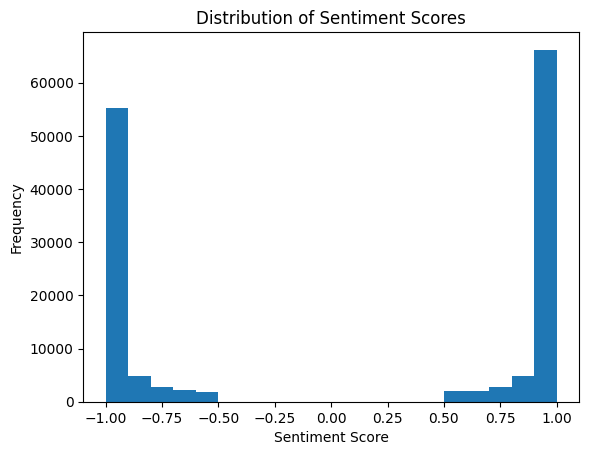

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['sentiment'], bins=20)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import re

def clean_prompt(prompt):
    # Use regex to find URLs in the prompt
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    # Replace any URLs with ''
    cleaned_prompt = re.sub(url_pattern, '', prompt)
    # Find the index of the first '--' in the string,
    # '--' is a prefix for prompt parameter
    param_index = cleaned_prompt.find('--')
    # If '--' is found in the string, trim the string from there
    if param_index != -1:
        cleaned_prompt = cleaned_prompt[:param_index]
    # Remove occurrences of NUMBER:NUMBER, NUMBER::NUMBER, WORD:NUMBER, WORD::NUMBER
    pattern = r'\b(\w+::?\d+(\.\d+)?|\d+(\.\d+)?::?\w+)\b'
    cleaned_prompt = re.sub(pattern, '', cleaned_prompt)
    return cleaned_prompt.strip()  # strip() is used to remove leading/trailing white space

# Apply the function to the 'prompt' column and create a new 'cleaned_prompt' column
df['cleaned_prompt'] = df['prompt'].apply(clean_prompt)

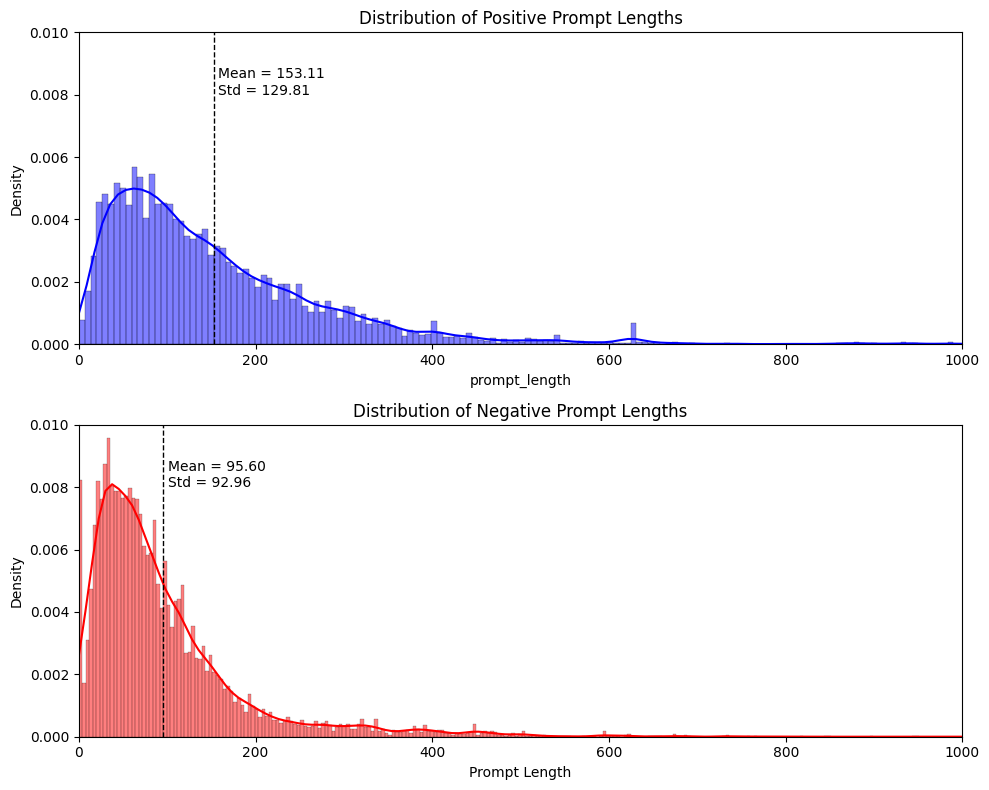

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the lengths of the prompts
df['prompt_length'] = df['cleaned_prompt'].apply(len)

# Separate the lengths based on their sentiment scores
positive_lengths = df[df['sentiment'] > 0]['prompt_length']
negative_lengths = df[df['sentiment'] < 0]['prompt_length']

# Create a figure and two subplots sharing the x-axis
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

# Calculate mean and standard deviation for positive lengths
pos_mean = positive_lengths.mean()
pos_std = positive_lengths.std()

# Plot the positive lengths in the first subplot
sns.histplot(positive_lengths, color='blue', kde=True, stat="density", common_norm=False, ax=axs[0])
axs[0].axvline(pos_mean, color='black', linestyle='dashed', linewidth=1)
axs[0].text(pos_mean+5, 0.008, f"Mean = {pos_mean:.2f}\nStd = {pos_std:.2f}")
axs[0].set_title('Distribution of Positive Prompt Lengths')
axs[0].set_ylabel('Density')

# Calculate mean and standard deviation for negative lengths
neg_mean = negative_lengths.mean()
neg_std = negative_lengths.std()

# Plot the negative lengths in the second subplot
sns.histplot(negative_lengths, color='red', kde=True, stat="density", common_norm=False, ax=axs[1])
axs[1].axvline(neg_mean, color='black', linestyle='dashed', linewidth=1)
axs[1].text(neg_mean+5, 0.008, f"Mean = {neg_mean:.2f}\nStd = {neg_std:.2f}")
axs[1].set_title('Distribution of Negative Prompt Lengths')
axs[1].set_xlabel('Prompt Length')
axs[1].set_ylabel('Density')

# Limit the x-axis and y-axis
for ax in axs:
    ax.set_xlim(0, 1000)
    ax.set_ylim(0, 0.01)

# Display the figure
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the lengths of the prompts
df['prompt_length'] = df['cleaned_prompt'].apply(len)

# Compute mean, median, and standard deviation for overall prompt lengths
overall_mean = df['prompt_length'].mean()
overall_median = df['prompt_length'].median()
overall_std = df['prompt_length'].std()

# Print overall statistics
print(f"Overall prompt length statistics:")
print(f"Mean: {overall_mean}")
print(f"Median: {overall_median}")
print(f"Standard Deviation: {overall_std}")

# Separate the lengths based on their sentiment scores
positive_lengths = df[df['sentiment'] > 0]['prompt_length']
negative_lengths = df[df['sentiment'] < 0]['prompt_length']

# Compute mean, median, and standard deviation for positive prompt lengths
positive_mean = positive_lengths.mean()
positive_median = positive_lengths.median()
positive_std = positive_lengths.std()

# Print positive statistics
print(f"\nPositive sentiment prompt length statistics:")
print(f"Mean: {positive_mean}")
print(f"Median: {positive_median}")
print(f"Standard Deviation: {positive_std}")

# Compute mean, median, and standard deviation for negative prompt lengths
negative_mean = negative_lengths.mean()
negative_median = negative_lengths.median()
negative_std = negative_lengths.std()

# Print negative statistics
print(f"\nNegative sentiment prompt length statistics:")
print(f"Mean: {negative_mean}")
print(f"Median: {negative_median}")
print(f"Standard Deviation: {negative_std}")

Overall prompt length statistics:
Mean: 126.48958505652054
Median: 92.0
Standard Deviation: 117.77974513712887

Positive sentiment prompt length statistics:
Mean: 153.1104908565929
Median: 118.0
Standard Deviation: 129.80586240659125

Negative sentiment prompt length statistics:
Mean: 95.5993447993448
Median: 70.0
Standard Deviation: 92.95535715647316


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import string

# You might need to download the stop words and punctuation using the following command:
nltk.download('stopwords')
nltk.download('punkt')

# Separate the prompts based on their sentiment scores
positive_prompts = df[df['sentiment'] > 0]['cleaned_prompt']
negative_prompts = df[df['sentiment'] < 0]['cleaned_prompt']

# Concatenate the positive and negative prompts into two large strings
positive_text = ' '.join(positive_prompts)
negative_text = ' '.join(negative_prompts)

# You might need to download the stop words and punctuation using the following command:
nltk.download('stopwords')
nltk.download('punkt')

# Tokenize the text into individual words
positive_words = word_tokenize(positive_text)
negative_words = word_tokenize(negative_text)

# Remove stop words and punctuation
stop_words = set(stopwords.words('english'))
exclude = set(string.punctuation)
positive_words = [word for word in positive_words if word.casefold() not in stop_words and word not in exclude]
negative_words = [word for word in negative_words if word.casefold() not in stop_words and word not in exclude]

# Count the frequency of each word
positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)

# Calculate word frequencies
positive_word_frequencies = {word: count / len(positive_words) for word, count in positive_word_counts.items()}
negative_word_frequencies = {word: count / len(negative_words) for word, count in negative_word_counts.items()}

# Calculate differences in word frequencies
positive_only_frequencies = {word: positive_word_frequencies[word] - negative_word_frequencies.get(word, 0) for word in positive_word_frequencies}
negative_only_frequencies = {word: negative_word_frequencies[word] - positive_word_frequencies.get(word, 0) for word in negative_word_frequencies}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


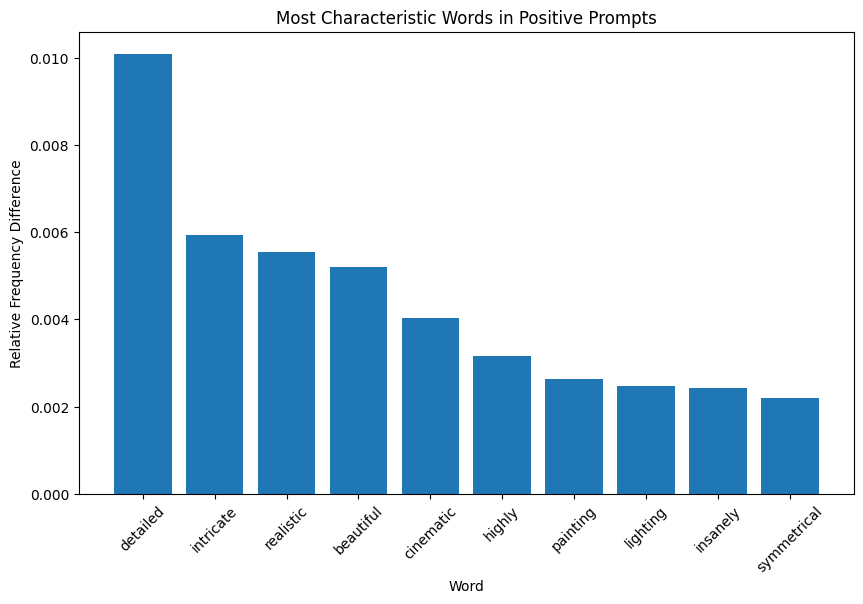

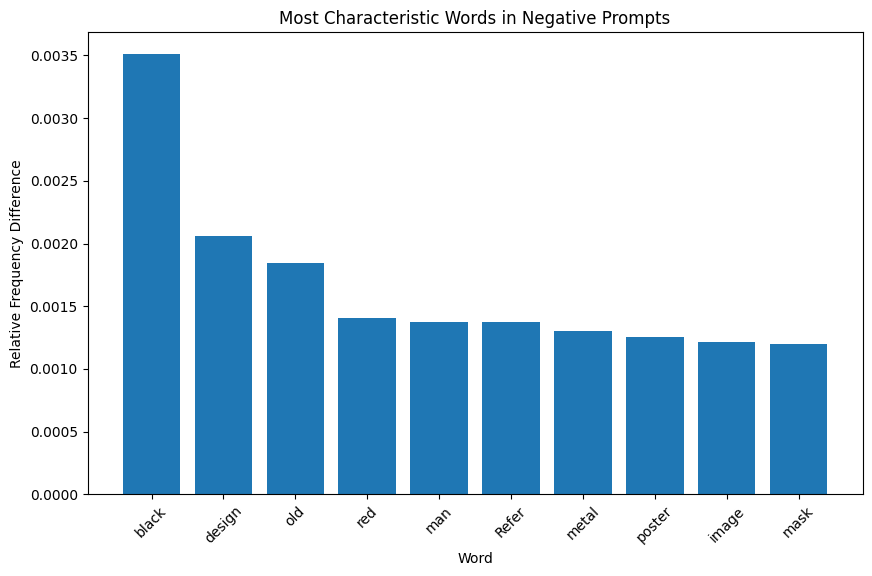

In [ ]:
# Get the 10 most common words in each set
positive_common_words = sorted(positive_only_frequencies.items(), key=lambda item: item[1], reverse=True)[:10]
negative_common_words = sorted(negative_only_frequencies.items(), key=lambda item: item[1], reverse=True)[:10]

# Create bar plots
plt.figure(figsize=(10, 6))  # Specify the figure size
plt.bar(*zip(*positive_common_words), width=0.8)
plt.title('Most Characteristic Words in Positive Prompts')
plt.xlabel('Word')
plt.ylabel('Relative Frequency Difference')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.show()

plt.figure(figsize=(10, 6))  # Specify the figure size
plt.bar(*zip(*negative_common_words), width=0.8)
plt.title('Most Characteristic Words in Negative Prompts')
plt.xlabel('Word')
plt.ylabel('Relative Frequency Difference')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.show()

In [ ]:
# Tokenize the text into individual words for all prompts
all_prompts = ' '.join(df['cleaned_prompt'])
all_words = word_tokenize(all_prompts)
all_word_counts = Counter(all_words)
all_word_frequencies = {word: count / len(all_words) for word, count in all_word_counts.items()}

# Print top 10 words for each sentiment group
print("Top 10 words in Positive Prompts")
for word, freq in positive_common_words:
    print(f"Word: {word}")
    print(f"Frequency in Positive Prompts: {positive_word_frequencies[word]}")
    print(f"Frequency in Negative Prompts: {negative_word_frequencies.get(word, 0)}")
    print(f"Frequency in All Prompts: {all_word_frequencies.get(word, 0)}")
    print("\n")

print("Top 10 words in Negative Prompts")
for word, freq in negative_common_words:
    print(f"Word: {word}")
    print(f"Frequency in Positive Prompts: {positive_word_frequencies.get(word, 0)}")
    print(f"Frequency in Negative Prompts: {negative_word_frequencies[word]}")
    print(f"Frequency in All Prompts: {all_word_frequencies.get(word, 0)}")
    print("\n")


Top 10 words in Positive Prompts
Word: detailed
Frequency in Positive Prompts: 0.01605724776505193
Frequency in Negative Prompts: 0.0059702760303520135
Frequency in All Prompts: 0.007832171382401902


Word: intricate
Frequency in Positive Prompts: 0.007074660888444459
Frequency in Negative Prompts: 0.0011402596600327407
Frequency in All Prompts: 0.003116772679244717


Word: realistic
Frequency in Positive Prompts: 0.009120956088459295
Frequency in Negative Prompts: 0.003582937803082562
Frequency in All Prompts: 0.004491844901545463


Word: beautiful
Frequency in Positive Prompts: 0.006638155952087164
Frequency in Negative Prompts: 0.0014298289867904909
Frequency in All Prompts: 0.0030051400066979602


Word: cinematic
Frequency in Positive Prompts: 0.0109468590902153
Frequency in Negative Prompts: 0.006922637371688614
Frequency in All Prompts: 0.005978838252911176


Word: highly
Frequency in Positive Prompts: 0.0043022839478875875
Frequency in Negative Prompts: 0.0011338247861047907
Fre

In [ ]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


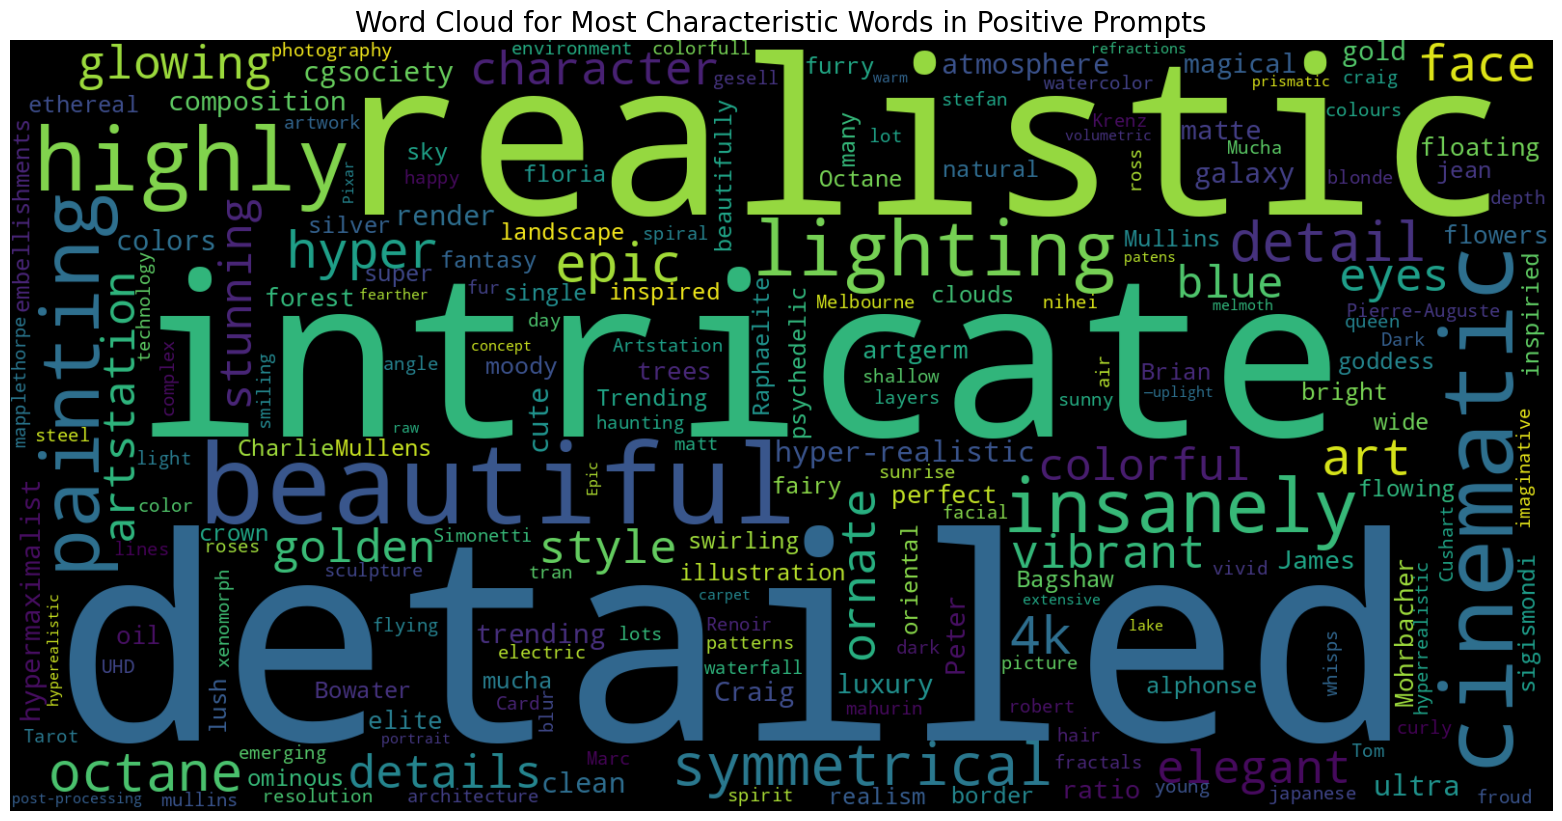

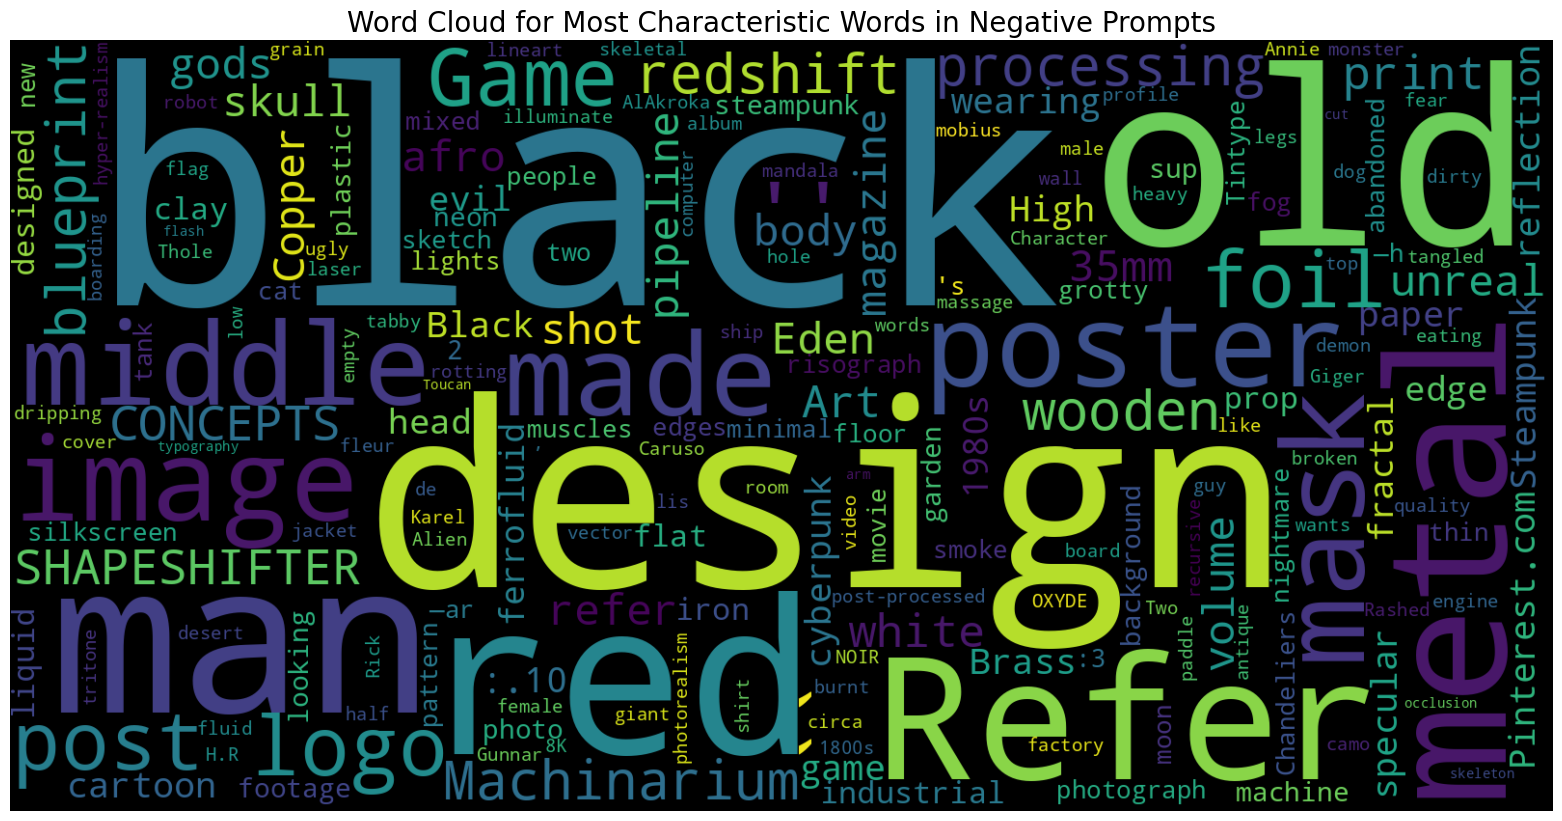

In [ ]:
from wordcloud import WordCloud

# Generate a word cloud image for positive words
wordcloud = WordCloud(width=1600, height=800, background_color="black").generate_from_frequencies(positive_only_frequencies)
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.title('Word Cloud for Most Characteristic Words in Positive Prompts', fontsize=20)  # Increase title size
plt.show()

# Generate a word cloud image for negative words
wordcloud = WordCloud(width=1600, height=800, background_color="black").generate_from_frequencies(negative_only_frequencies)
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.title('Word Cloud for Most Characteristic Words in Negative Prompts', fontsize=20)  # Increase title size
plt.show()


In [ ]:
from tqdm.notebook import tqdm
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from skimage import io
import requests
from io import BytesIO
from PIL import Image

def get_top_colors(image_url, top_colors=5, color_quantization=32):
    try:
        # Set a User-Agent for the request
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
        }

        # Download the image
        response = requests.get(image_url, headers=headers)
        img = Image.open(BytesIO(response.content))
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Reshape the image to be a list of pixels
        pixels = img.reshape(-1, 3)

        # Perform k-means clustering to find the most dominant colors
        kmeans = KMeans(n_clusters=top_colors, n_init=1)
        kmeans.fit(pixels)

        # Get the RGB values of the cluster centers
        colors = kmeans.cluster_centers_

        # Quantize the colors and make sure they are within the correct range
        colors = np.clip((colors / color_quantization).round() * color_quantization, 0, 255)

        return colors

    except Exception as e:
        print(f"Error processing image {image_url}: {e}")
        return []



# Take a random sample of images from each sentiment group
SEED = 42
SAMPLES = 100
positive_sample = df[df['sentiment'] > 0]['generated_url'].sample(n=SAMPLES, random_state=SEED)
negative_sample = df[df['sentiment'] < 0]['generated_url'].sample(n=SAMPLES, random_state=SEED)

# Extract the top colors from each image in the sample
positive_colors = [get_top_colors(url) for url in tqdm(positive_sample)]
negative_colors = [get_top_colors(url) for url in tqdm(negative_sample)]

# Aggregate the colors to find the most common ones
positive_common_colors = Counter([tuple(color) for colors in positive_colors for color in colors])
negative_common_colors = Counter([tuple(color) for colors in negative_colors for color in colors])


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

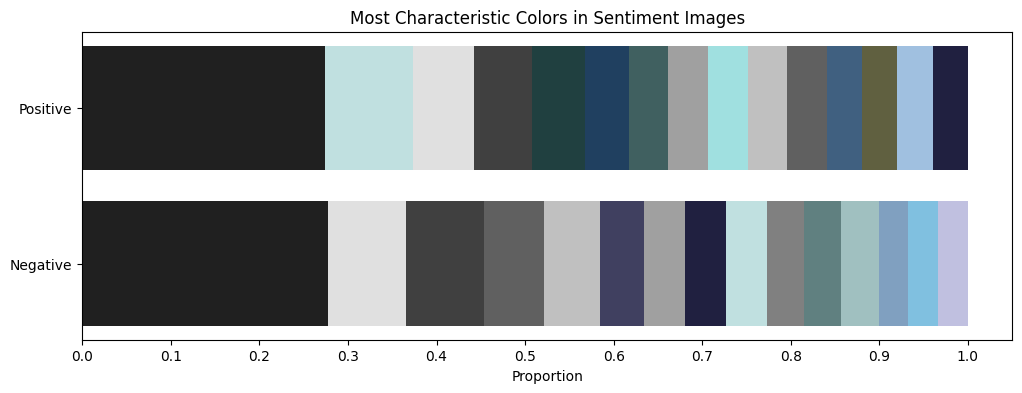

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

# Get the top n colors
TOP_N_COLORS = 15
positive_top_colors = positive_common_colors.most_common(TOP_N_COLORS)
negative_top_colors = negative_common_colors.most_common(TOP_N_COLORS)

# Get counts and colors for negative sentiment
negative_counts = np.array([count for color, count in negative_top_colors])
negative_colors = [tuple(val/255 for val in color) for color, count in negative_top_colors]

# Normalize the counts so that they represent proportions
negative_counts = negative_counts / negative_counts.sum()

# Create a single stacked bar for the negative sentiment colors
bottom = 0
for count, color in zip(negative_counts, negative_colors):
    ax.barh('Negative', count, color=color, left=bottom)
    bottom += count

# Get counts and colors for positive sentiment
positive_counts = np.array([count for color, count in positive_top_colors])
positive_colors = [tuple(val/255 for val in color) for color, count in positive_top_colors]

# Normalize the counts so that they represent proportions
positive_counts = positive_counts / positive_counts.sum()

# Create a single stacked bar for the positive sentiment colors
bottom = 0
for count, color in zip(positive_counts, positive_colors):
    ax.barh('Positive', count, color=color, left=bottom)
    bottom += count

ax.set_title('Most Characteristic Colors in Sentiment Images')
ax.set_xlabel('Proportion')

# Add more ticks to the x-axis
plt.xticks(np.arange(0, 1.1, 0.1))

plt.show()